In [115]:
# import libraries
import pandas as pd
import numpy as np
from numpy import array
import math

import time
import datetime
from datetime import date, timedelta

# import model libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping

# import viz libraries
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [116]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [117]:
today_date = date.today()
days = pd.date_range(start=today_date, periods=3)
yesterday = today_date - timedelta(days=1)
yesterday = yesterday.strftime("%Y-%m-%d")
today_date = today_date.strftime("%Y-%m-%d")

In [118]:
# set file path
crude = "../historical-dataset/Crude Oil Prices.csv"

# load dataset
main_crude = pd.read_csv(crude, parse_dates=["Date"], index_col=["Date"]).sort_index(ascending=True)

In [119]:
main_crude

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
1994-01-03,14.56,14.10,14.65,14.11,37.38K,2.75%
1994-01-04,14.67,14.55,14.72,14.35,37.75K,0.76%
1994-01-05,15.34,14.50,15.42,14.65,69.69K,4.57%
1994-01-06,15.42,15.34,15.61,15.05,51.95K,0.52%
1994-01-07,15.32,15.40,15.46,15.23,31.71K,-0.65%
...,...,...,...,...,...,...
2023-01-06,73.69,73.96,75.45,73.25,NaN,-0.38%
2023-01-08,74.11,73.77,74.15,73.70,NaN,+0.57%
2023-01-09,74.69,74.10,76.72,74.06,NaN,+0.78%


<h3> Preprocess the data

In [120]:
main_crude.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,7404.0,53.723236,29.233561,-37.63,26.8900,51.035,75.0225,145.29
Open,7404.0,53.720041,29.232061,-14.00,26.8575,51.005,75.0200,145.19
High,7404.0,54.547878,29.595892,11.02,27.3800,51.965,75.9675,147.27
Low,7404.0,52.843707,28.822344,-40.32,26.4600,50.140,73.8800,143.22


In [121]:
main_crude[main_crude["Price"]<0]

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-04-20,-37.63,17.73,17.85,-40.32,247.95K,-305.97%


In [122]:
main_crude[main_crude["Low"]<0]

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-04-20,-37.63,17.73,17.85,-40.32,247.95K,-305.97%
2020-04-21,10.01,-14.00,13.86,-16.74,18.44K,-126.60%


In [123]:
# exclude negative price
main_crude = main_crude[main_crude["Price"]>0]
main_crude = main_crude[(main_crude["Open"]>0) & (main_crude["Low"]>0)]

main_crude.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,7402.0,53.741483,29.213796,10.72,26.9000,51.045,75.0275,145.29
Open,7402.0,53.734052,29.222414,10.74,26.8750,51.010,75.0200,145.19
High,7402.0,54.558333,29.593036,11.02,27.3825,51.980,75.9825,147.27
Low,7402.0,52.865694,28.794523,10.07,26.4800,50.145,73.8800,143.22


In [124]:
# ambil harga sampai kemarin
main_crude = main_crude[:yesterday]
main_crude.tail()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2023-01-05,73.97,73.37,74.92,72.47,NaN,+0.80%
2023-01-06,73.69,73.96,75.45,73.25,NaN,-0.38%
2023-01-08,74.11,73.77,74.15,73.70,NaN,+0.57%
2023-01-09,74.69,74.10,76.72,74.06,NaN,+0.78%
2023-01-10,74.59,74.70,75.92,73.84,NaN,-0.13%


In [125]:
# extract close price
df = main_crude.reset_index()["Price"]
df.shape

(7401,)

In [126]:
df

0       14.56
1       14.67
2       15.34
3       15.42
4       15.32
        ...  
7396    73.97
7397    73.69
7398    74.11
7399    74.69
7400    74.59
Name: Price, Length: 7401, dtype: float64

In [127]:
# normalize
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

df

array([[0.02853533],
       [0.02935275],
       [0.03433157],
       ...,
       [0.47105596],
       [0.47536598],
       [0.47462287]])

In [128]:
train_size = int(len(df)*0.7)
test_size = len(df) - train_size
train_data, test_data = df[0:train_size,:], df[train_size:len(df),:1]
len(train_data), len(test_data)

(5180, 2221)

In [129]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
        X, y = [], []
        for i in range(len(sequence)):
                # find the end of this pattern
                end_ix = i + n_steps_in
                out_end_ix = end_ix + n_steps_out
                # check if we are beyond the sequence
                if out_end_ix > len(sequence):
                        break
                # gather input and output parts of the pattern
                seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
                X.append(seq_x)
                y.append(seq_y)
        return array(X), array(y)

In [130]:
# choose a number of time steps
n_steps_in = 60
n_steps_out = 3

# split into samples
X_train, y_train = split_sequence(train_data, n_steps_in, n_steps_out)
X_test, y_valid = split_sequence(test_data, n_steps_in, n_steps_out)

In [131]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_valid.shape)

(5118, 60, 1)
(5118, 3, 1)
(2159, 60, 1)
(2159, 3, 1)


(None, None)

In [132]:
n_features = 1

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [133]:
model = Sequential()
model.add(LSTM(50, activation="relu", return_sequences=True, input_shape=(n_steps_in, n_features), name="LSTM-Crude-Oil-First-Layer"))
model.add(LSTM(50, name="LSTM-Crude-Oil-Second-Layer"))
model.add(Dropout(0.1, name="dropout"))
model.add(Dense(n_steps_out))
model.compile(optimizer="adam", loss="mse")

# Set up the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)

In [134]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM-Crude-Oil-First-Layer   (None, 60, 50)           10400     
 (LSTM)                                                          
                                                                 
 LSTM-Crude-Oil-Second-Layer  (None, 50)               20200     
  (LSTM)                                                         
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 153       
                                                                 
Total params: 30,753
Trainable params: 30,753
Non-trainable params: 0
_________________________________________________________________


In [135]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.3, validation_data=(X_test, y_valid), callbacks=[early_stopping])

Epoch 1/50
80/80 [==============================] - 14s 134ms/step - loss: 0.0150 - val_loss: 9.2877e-04
Epoch 2/50
80/80 [==============================] - 11s 139ms/step - loss: 0.0016 - val_loss: 8.3443e-04
Epoch 3/50
80/80 [==============================] - 11s 141ms/step - loss: 0.0014 - val_loss: 7.7659e-04
Epoch 4/50
80/80 [==============================] - 12s 148ms/step - loss: 0.0013 - val_loss: 7.6029e-04
Epoch 5/50
80/80 [==============================] - 12s 151ms/step - loss: 0.0014 - val_loss: 7.7116e-04
Epoch 6/50
80/80 [==============================] - 12s 150ms/step - loss: 0.0012 - val_loss: 6.3682e-04
Epoch 7/50
80/80 [==============================] - 12s 154ms/step - loss: 0.0011 - val_loss: 6.2838e-04
Epoch 8/50
80/80 [==============================] - 12s 152ms/step - loss: 0.0012 - val_loss: 5.8592e-04
Epoch 9/50
80/80 [==============================] - 12s 155ms/step - loss: 0.0011 - val_loss: 5.7641e-04
Epoch 10/50
80/80 [==============================] - 12

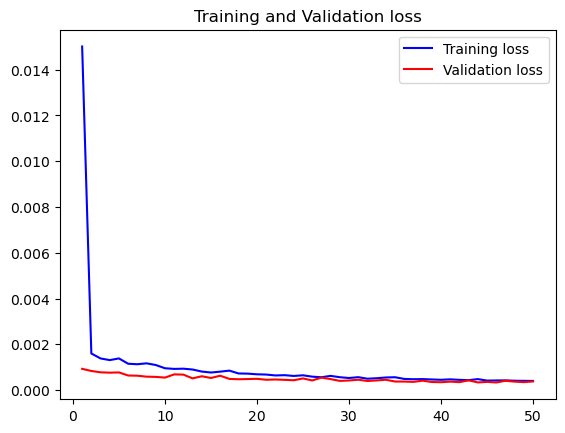

In [136]:
# viz loss
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

# train - validation loss 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [137]:
# # save model
# model.save("../models/multistep-crude-oil-model.h5")

In [138]:
# # save model
# model.save("../models/multistep-crude-oil-model-ver-2.h5")

In [139]:
# save model
model.save("../models/multistep-crude-oil-model-ver-3.h5")

In [140]:
# predict and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

68/68 [==============================] - 2s 36ms/step


In [141]:
y_valid = y_valid.reshape((y_valid.shape[0], y_valid.shape[1]))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_train

array([[0.02675188, 0.02719774, 0.03024448],
       [0.02719774, 0.03024448, 0.03767556],
       [0.03024448, 0.03767556, 0.03730401],
       ...,
       [0.64397711, 0.64055882, 0.64367987],
       [0.64055882, 0.64367987, 0.6459835 ],
       [0.64367987, 0.6459835 , 0.64917887]])

In [142]:
train_rmse = math.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = math.sqrt(mean_squared_error(y_valid, test_predict))

print("train rmse: ", train_rmse)
print("test rmse: ", test_rmse)

train rmse:  0.01691741448401356
test rmse:  0.01944183285005239


In [143]:
# transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [144]:
train_predict.shape

(5118, 3)

In [145]:
train_predict

array([[14.740804 , 14.632011 , 14.6413555],
       [14.584986 , 14.473901 , 14.488487 ],
       [14.462938 , 14.34755  , 14.364014 ],
       ...,
       [95.8729   , 95.836266 , 95.55527  ],
       [95.62186  , 95.587906 , 95.289314 ],
       [95.242874 , 95.218056 , 94.91493  ]], dtype=float32)

In [146]:
test_predict.shape

(2159, 3)

In [147]:
test_predict

array([[78.27005 , 78.30241 , 78.169395],
       [76.71462 , 76.755325, 76.657005],
       [76.41453 , 76.430695, 76.306656],
       ...,
       [76.0633  , 76.07949 , 76.02631 ],
       [74.14528 , 74.180984, 74.15657 ],
       [72.79337 , 72.82587 , 72.7904  ]], dtype=float32)

In [148]:
main_crude.shape

(7401, 6)

In [149]:
train_predict_df = pd.DataFrame(train_predict)
train_predict_df = train_predict_df[[0]]
train_predict_df.columns = ["PredictPrice"]

train_date = main_crude.reset_index(drop=False)
train_date = train_date[62:len(train_predict_df)]
train_date = train_date["Date"].reset_index(drop=True)

train_predict_df.insert(0, "Date", train_date)
train_predict_df.set_index("Date", inplace=True)
train_predict_df = train_predict_df[0:-62]

train_predict_df.tail()

,PredictPrice
Date,
2014-05-09,97.416946
2014-05-12,98.075485
2014-05-13,98.313370
2014-05-14,98.132874
2014-05-15,98.202232


In [150]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_df = test_predict_df[[0]]
test_predict_df.columns = ["PredictPrice"]

test_date = main_crude.reset_index(drop=False)
test_date = test_date[len(train_data)+62:]
test_date = test_date["Date"].reset_index(drop=True)

test_predict_df.insert(0, "Date", test_date)
test_predict_df.set_index("Date", inplace=True)
test_predict_df = test_predict_df

test_predict_df

,PredictPrice
Date,
2014-11-06,78.270050
2014-11-07,76.714622
2014-11-10,76.414528
2014-11-11,76.344917
2014-11-12,76.729576
...,...
2023-01-05,78.367928
2023-01-06,77.349182
2023-01-08,76.063301


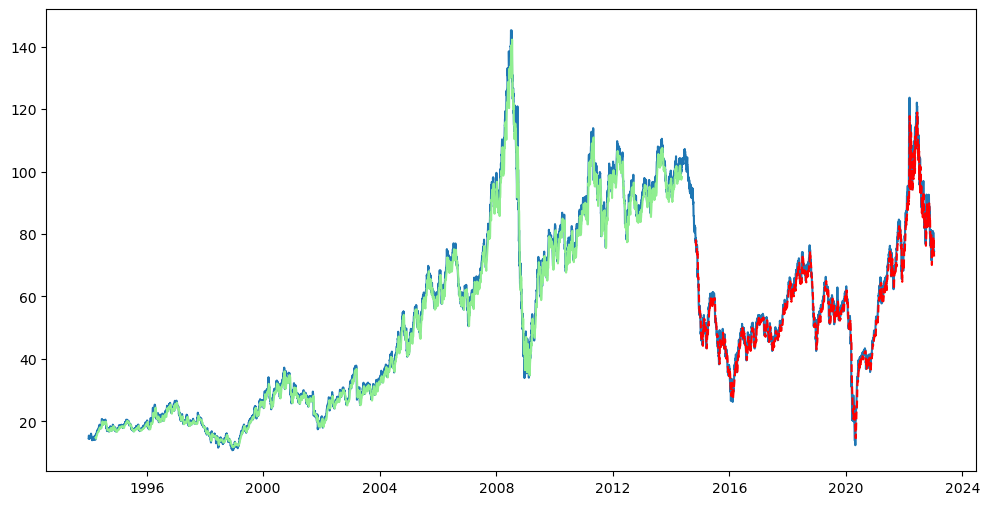

In [151]:
# plotting
plt.gcf().set_size_inches(12, 6, forward=True)
currentFig = plt.gcf()

plt.plot(main_crude["Price"], label="Actual Price")
plt.plot(train_predict_df["PredictPrice"], label="Predict Price - Train Dataset", color="lightgreen")
plt.plot(test_predict_df["PredictPrice"], label="Predict Price - Train Dataset", color="r", linestyle="dashed")
plt.show()

forecast 3 days ahead

In [152]:
# predict using last 30 days data
input_price = test_data[-60:].reshape((1, 60, n_features))
yhat = model.predict(input_price, verbose=0)

# transformback to original form
new_predict=scaler.inverse_transform(yhat)

# store to dataframe
prices = []

for i in new_predict[0]:
        prices.append(i)

new_df = pd.DataFrame(prices)
new_df.insert(0, "Date", days)
new_df = new_df.rename(columns={0:"PredictPrice"})
new_df["PredictPrice"] = new_df["PredictPrice"]

new_df.sort_index(inplace=True)
new_df = new_df.set_index(pd.DatetimeIndex(new_df["Date"])) # set index using date
new_df.drop(columns="Date", inplace=True) # drop date column since already have datetimeindex
new_df.columns = ["Price"] # rename column

prices_df = main_crude[["Price"]].copy() # copy hist dataset
new_rows = new_df[["Price"]] # take forecasted prices
prices_df = prices_df.append(new_rows) # append historical + future prices

prices_df.tail(25)

,Price
Date,
2022-12-13,74.000000
2022-12-14,76.140000
2022-12-15,76.250000
2022-12-16,74.450000
2022-12-19,75.530000
2022-12-20,76.230000
2022-12-21,78.240000
2022-12-22,78.450000
2022-12-23,79.340000


## buat loop function

In [153]:
hist_df = main_crude.copy(deep=True)
hist_df.reset_index(inplace=True)
hist_df.to_csv("../historical-dataset/for-process/crude-oil-hist-for-process.csv", index=False)

# load again
new_crude = "../historical-dataset/for-process/crude-oil-hist-for-process.csv"
new_hist_df = pd.read_csv(new_crude, parse_dates=["Date"], index_col=["Date"]).sort_index(ascending=True)

In [187]:
def forecast_future_price(dataframe):

        # ----- initiate workspace -----
        
        today_date = date.today()
        days = pd.date_range(start=today_date, periods=3)
        yesterday = today_date - timedelta(days=1)
        yesterday = yesterday.strftime("%Y-%m-%d")
        today_date = today_date.strftime("%Y-%m-%d")

        hist_df = dataframe

        # load trained model
        use_model = load_model("../models/multistep-crude-oil-model-ver-3.h5")

        df = hist_df.reset_index()["Price"]
        # normalize
        scaler = MinMaxScaler(feature_range=(0,1))
        df = scaler.fit_transform(np.array(df).reshape(-1,1))

        train_size = int(len(df)*0.7)
        test_size = len(df) - train_size
        train_data, test_data = df[0:train_size,:], df[train_size:len(df),:1]

        # predict using last 60 days data
        n_features = 1
        input_price = test_data[-60:].reshape((1, 60, n_features))
        yhat = use_model.predict(input_price, verbose=0)

        # transformback to original form
        new_predict=scaler.inverse_transform(yhat)

        # store to dataframe
        prices = []

        for i in new_predict[0]:
                prices.append(i)

        new_df = pd.DataFrame(prices)
        new_df.insert(0, "Date", days)
        new_df = new_df.rename(columns={0:"PredictPrice"})
        new_df["PredictPrice"] = new_df["PredictPrice"]

        new_df.sort_index(inplace=True)
        new_df = new_df.set_index(pd.DatetimeIndex(new_df["Date"])) # set index using date
        new_df.drop(columns="Date", inplace=True) # drop date column since already have datetimeindex
        new_df.columns = ["Price"] # rename column

        prices_df = main_crude[["Price"]].copy() # copy hist dataset
        new_rows = new_df[["Price"]] # take forecasted prices
        prices_df = prices_df.append(new_rows) # append historical + future prices
        prices_df["Price"] = np.round(prices_df["Price"], 2)

        return prices_df

In [188]:
new_df1 = main_crude.copy(deep=True)
new_df1 = forecast_future_price(new_df1)

new_df1

,Price
Date,
1994-01-03,14.56
1994-01-04,14.67
1994-01-05,15.34
1994-01-06,15.42
1994-01-07,15.32
...,...
2023-01-09,74.69
2023-01-10,74.59
2023-01-11,73.27


In [190]:
latest_date = new_df1.index.values[-1]
tomorrow = latest_date + timedelta(days=1)
days = pd.date_range(start=tomorrow, periods=3)

days

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('O')

In [184]:
new_df2 = forecast_future_price(new_df1)

new_df2

,Price
Date,
1994-01-03,14.56
1994-01-04,14.67
1994-01-05,15.34
1994-01-06,15.42
1994-01-07,15.32
...,...
2023-01-09,74.69
2023-01-10,74.59
2023-01-12,72.12


In [ ]:
# # set file path
# crude = "../historical-dataset/Crude Oil Prices.csv"

# # load dataset
# main_crude = pd.read_csv(crude, parse_dates=["Date"], index_col=["Date"]).sort_index(ascending=True)

In [165]:
count = 5
while count < 5:
        # load again
        new_crude = "../historical-dataset/for-process/crude-oil-hist-for-process.csv"
        new_hist_df = pd.read_csv(new_crude, parse_dates=["Date"], index_col=["Date"]).sort_index(ascending=True)

        new_df = forecast_future_price(new_hist_df)
        count += 1
        

forecast 14 days ahead

In [75]:
# predict using last 30 days data
input_price = test_data[-60:].reshape((1, 60, n_features))
yhat = model.predict(input_price, verbose=0)

# transformback to original form
new_predict=scaler.inverse_transform(yhat)

# store to dataframe
prices = []

for i in new_predict[0]:
        prices.append(i)

new_df = pd.DataFrame(prices)
new_df.insert(0, "Date", days)
new_df = new_df.rename(columns={0:"PredictPrice"})
new_df["PredictPrice"] = new_df["PredictPrice"]

new_df.sort_index(inplace=True)
new_df = new_df.set_index(pd.DatetimeIndex(new_df["Date"])) # set index using date
new_df.drop(columns="Date", inplace=True) # drop date column since already have datetimeindex
new_df.columns = ["Price"] # rename column

prices_df = main_crude[["Price"]].copy() # copy hist dataset
new_rows = new_df[["Price"]] # take forecasted prices
prices_df = prices_df.append(new_rows) # append historical + future prices

prices_df.tail(25)

,Price
Date,
2022-12-21,78.240000
2022-12-22,78.450000
2022-12-23,79.340000
2022-12-26,80.970000
2022-12-27,79.770000
2022-12-28,78.600000
2022-12-29,78.610000
2022-12-30,80.470000
2023-01-02,80.470000
